# Giallo Zafferano Dataset Analysis

In [1]:
import json
import numpy as np
import spacy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

/Users/christianmoiola/VS Code/MMTRC/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Loading the dataset

In [2]:
def load_dataset(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

english_N1000 = load_dataset('dataset/english_N1000_2025-02-11.json')
italian_from_eng_N1000 = load_dataset('dataset/italian_from_eng_N1000_2025-02-11.json')
italian_N50 = load_dataset('dataset/italian_N50_2024-11-29.json')
italian_N1000 = load_dataset('dataset/italian_N1000_2025-02-11.json')

dataset = {
    'english_N1000': english_N1000,
    'italian_from_eng_N1000': italian_from_eng_N1000,
    'italian_N50': italian_N50,
    'italian_N1000': italian_N1000
}

def remove_zero_length_receipes(data):
    """
    Remove recipes with zero length
    """
    return [recipe for recipe in data if len(recipe["steps"]) > 0]

for name, data in dataset.items():
    print(f"Removing zero length recipes from {name}")
    dataset[name] = remove_zero_length_receipes(data)
    print(f"Removed {len(data) - len(dataset[name])} recipes")

Removing zero length recipes from english_N1000
Removed 1 recipes
Removing zero length recipes from italian_from_eng_N1000
Removed 1 recipes
Removing zero length recipes from italian_N50
Removed 0 recipes
Removing zero length recipes from italian_N1000
Removed 8 recipes


### Number of recipes in each partiton

In [3]:
for name, partition in dataset.items():
    print(f"Number of recipes in {name} partition: {len(partition)}")

Number of recipes in english_N1000 partition: 670
Number of recipes in italian_from_eng_N1000 partition: 685
Number of recipes in italian_N50 partition: 32
Number of recipes in italian_N1000 partition: 629


### Min, Max, Mean and Standard Deviation of steps in each partition

In [4]:
def min_max_mean_std_steps(dataset):
    mean_length = np.mean([len(el["steps"]) for el in dataset])
    max_length = np.max([len(el["steps"]) for el in dataset])
    min_length = np.min([len(el["steps"]) for el in dataset])
    standard_deviation = np.std([len(el["steps"]) for el in dataset])
    return min_length, max_length, mean_length, standard_deviation

for name, partition in dataset.items():
    min_length, max_length, mean_length, std_length = min_max_mean_std_steps(partition)
    print(f"{name} partition: min: {min_length}, max: {max_length}, mean: {mean_length}, std: {std_length} of steps")

english_N1000 partition: min: 6, max: 45, mean: 19.4955223880597, std: 6.961245231628599 of steps
italian_from_eng_N1000 partition: min: 6, max: 48, mean: 19.541605839416057, std: 7.087365568809845 of steps
italian_N50 partition: min: 6, max: 39, mean: 21.0, std: 8.147085368400163 of steps
italian_N1000 partition: min: 3, max: 42, mean: 19.211446740858506, std: 7.431176279419841 of steps


### Number of input examples (Sj+1) (Sj+2) (Sj+5) for each partiton

In [5]:
for name, partition in dataset.items():
    sj1 = 0
    sj2 = 0
    sj5 = 0
    for el in partition:
        sj1 += len(el["steps"]) - 1 if len(el["steps"]) > 1 else 0
        sj2 += len(el["steps"]) - 2 if len(el["steps"]) > 2 else 0
        sj5 += len(el["steps"]) - 5 if len(el["steps"]) > 5 else 0
    
    print(f"{name} partition: sj1: {sj1}, sj2: {sj2}, sj5: {sj5}")
            

english_N1000 partition: sj1: 12392, sj2: 11722, sj5: 9712
italian_from_eng_N1000 partition: sj1: 12701, sj2: 12016, sj5: 9961
italian_N50 partition: sj1: 640, sj2: 608, sj5: 512
italian_N1000 partition: sj1: 11455, sj2: 10826, sj5: 8943


## Semantic Analysis

### Tokenization dataset

In [6]:
nlp_eng = spacy.load("en_core_web_sm")
nlp_ita = spacy.load("it_core_news_sm")

def tokenize_text(text, language='en'):
    '''
    Tokenizes the text using spaCy and removes stop words and punctuation.
    '''
    if language == 'en':
        doc = nlp_eng(text["text"])
    elif language == 'it':
        doc = nlp_ita(text["text"])
    else:
        raise ValueError("Language not supported. Use 'en' for English or 'it' for Italian.")
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    return tokens

def tokenize_dataset(dataset, name):
    '''
    Tokenizes the steps in recipes using spaCy.
    The function takes a dataset as input and returns the dataset with tokenized steps as a new field.
    '''
    if name.startswith("italian"):
        language = 'it'
    elif name.startswith("english"):
        language = 'en'
    else:
        raise ValueError("Language not supported. Use 'english' or 'italian'.")
    for el in tqdm(dataset, desc=f"{language} Tokenizing steps...", unit="recipe"):
        el["tokenized_steps"] = [tokenize_text(step, language) for step in el["steps"]]
    return dataset

for name, partition in dataset.items():
    print(f"Tokenizing {name} partition...")
    dataset[name] = tokenize_dataset(partition, name)
    print(f"Tokenization complete for {name} partition.")

/Users/christianmoiola/VS Code/MMTRC/venv/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Tokenizing english_N1000 partition...


en Tokenizing steps...: 100%|██████████| 670/670 [00:38<00:00, 17.45recipe/s]


Tokenization complete for english_N1000 partition.
Tokenizing italian_from_eng_N1000 partition...


it Tokenizing steps...: 100%|██████████| 685/685 [00:39<00:00, 17.45recipe/s]


Tokenization complete for italian_from_eng_N1000 partition.
Tokenizing italian_N50 partition...


it Tokenizing steps...: 100%|██████████| 32/32 [00:02<00:00, 15.28recipe/s]


Tokenization complete for italian_N50 partition.
Tokenizing italian_N1000 partition...


it Tokenizing steps...: 100%|██████████| 629/629 [00:36<00:00, 17.32recipe/s]

Tokenization complete for italian_N1000 partition.


### Min, Max, Standard Deviation of tokens for each step

In [7]:
def count_tokens(dataset):
    '''
    Counts the number of tokens in each recipe's steps.
    The function takes a dataset as input and returns the dataset with token counts as a new field.
    '''
    for el in dataset:
       el["token_count"] = [len(step) for step in el["tokenized_steps"] if len(step) > 0]
    return dataset

for name, partition in dataset.items():
    dataset[name] = count_tokens(partition)

def min_max_mean_std_tokens_steps(dataset):
    '''
    Computes the minimum, maximum, mean, and standard deviation of token counts in the dataset.
    The function takes a dataset as input and returns these statistics.
    '''
    mean_length = np.mean([step for el in dataset for step in el["token_count"]])
    max_length = np.max([step for el in dataset for step in el["token_count"]])
    min_length = np.min([step for el in dataset for step in el["token_count"]])
    standard_deviation = np.std([step for el in dataset for step in el["token_count"]])
    return min_length, max_length, mean_length, standard_deviation

for name, partition in dataset.items():
    min_length, max_length, mean_length, std_length = min_max_mean_std_tokens_steps(partition)
    print(f"{name} partition: min: {min_length}, max: {max_length}, mean: {mean_length}, std: {std_length} of tokens for step")

english_N1000 partition: min: 1, max: 100, mean: 6.260529344073648, std: 4.532229064728398 of tokens for step
italian_from_eng_N1000 partition: min: 1, max: 49, mean: 6.532112845138055, std: 4.479178986759654 of tokens for step
italian_N50 partition: min: 1, max: 33, mean: 7.39344262295082, std: 5.065021504676269 of tokens for step
italian_N1000 partition: min: 1, max: 51, mean: 6.8323089700996675, std: 4.652442217687702 of tokens for step


### Min, Max, Standard Deviation of tokens for each receipe

In [8]:
def min_max_mean_std_tokens_recipes(dataset):
    '''
    Computes the minimum, maximum, mean, and standard deviation of token counts in the recipes.
    The function takes a dataset as input and returns these statistics.
    '''
    mean_length = np.mean([sum(el["token_count"])for el in dataset])
    max_length = np.max([sum(el["token_count"])for el in dataset])
    min_length = np.min([sum(el["token_count"])for el in dataset])
    standard_deviation = np.std([sum(el["token_count"])for el in dataset])
    return min_length, max_length, mean_length, standard_deviation

for name, partition in dataset.items():
    min_length, max_length, mean_length, std_length = min_max_mean_std_tokens_recipes(partition)
    print(f"{name} partition: min: {min_length}, max: {max_length}, mean: {mean_length}, std: {std_length} of tokens for recipes")

english_N1000 partition: min: 30, max: 344, mean: 121.8, std: 48.9704327485687 of tokens for recipes
italian_from_eng_N1000 partition: min: 30, max: 381, mean: 127.0948905109489, std: 52.56721567359397 of tokens for recipes
italian_N50 partition: min: 42, max: 308, mean: 155.03125, std: 64.32898082075839 of tokens for recipes
italian_N1000 partition: min: 23, max: 360, mean: 130.7806041335453, std: 55.25762359722652 of tokens for recipes


### Frequency Distribuiton

Top 10 Most Frequent Words in english_N1000 partition: [('add', 2245), ('minutes', 1340), ('heat', 874), ('water', 853), ('place', 828), ('pour', 736), ('salt', 721), ('cut', 719), ('oil', 711), ('remove', 693)]
Number of words in english_N1000 partition: 3687


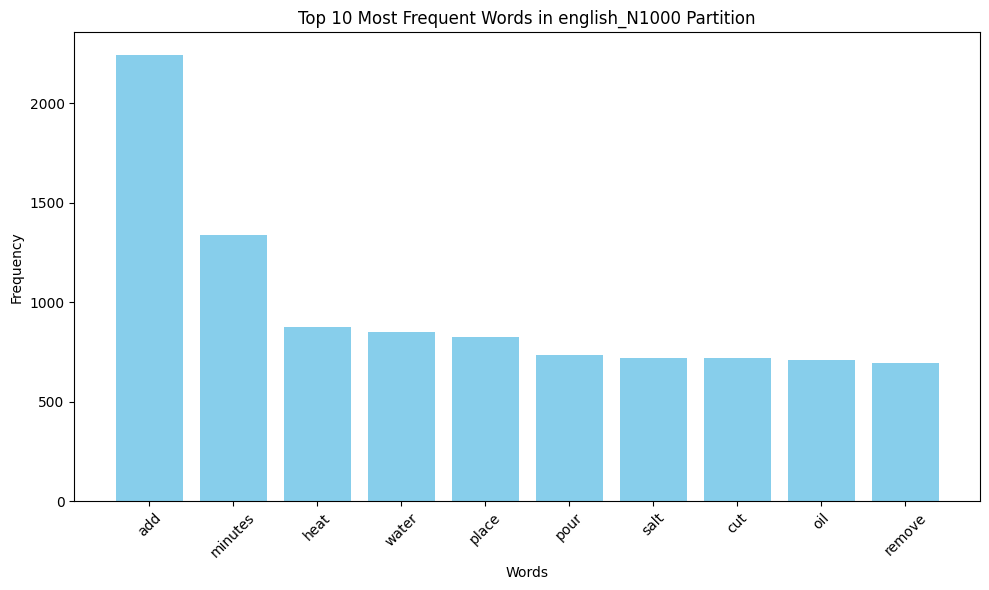

Top 10 Most Frequent Words in italian_from_eng_N1000 partition: [('i', 1658), ('minuti', 1252), ('aggiungete', 1146), ('versate', 982), ('l’', 935), ('acqua', 855), ('mescolate', 800), ('olio', 711), ('cottura', 632), ('unite', 604)]
Number of words in italian_from_eng_N1000 partition: 5978


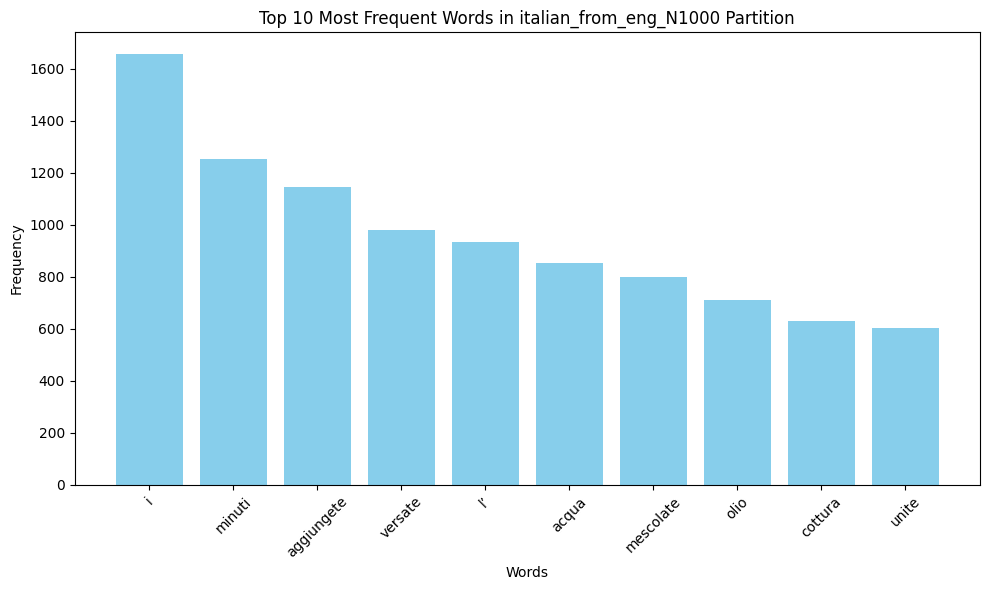

Top 10 Most Frequent Words in italian_N50 partition: [('i', 107), ('minuti', 74), ('l’', 66), ('aggiungete', 55), ('acqua', 43), ('versate', 36), ('composto', 36), ('forno', 34), ('ciotola', 33), ('olio', 33)]
Number of words in italian_N50 partition: 1501


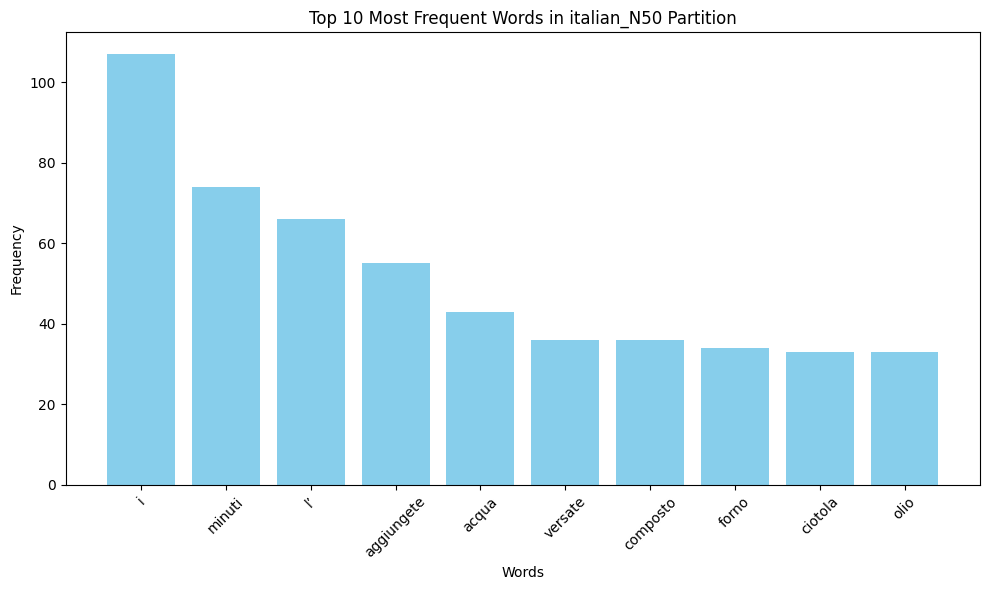

Top 10 Most Frequent Words in italian_N1000 partition: [('i', 1799), ('minuti', 1238), ('aggiungete', 980), ('l’', 925), ('versate', 876), ('acqua', 756), ('mescolate', 683), ('olio', 628), ('forno', 616), ('ciotola', 579)]
Number of words in italian_N1000 partition: 6056


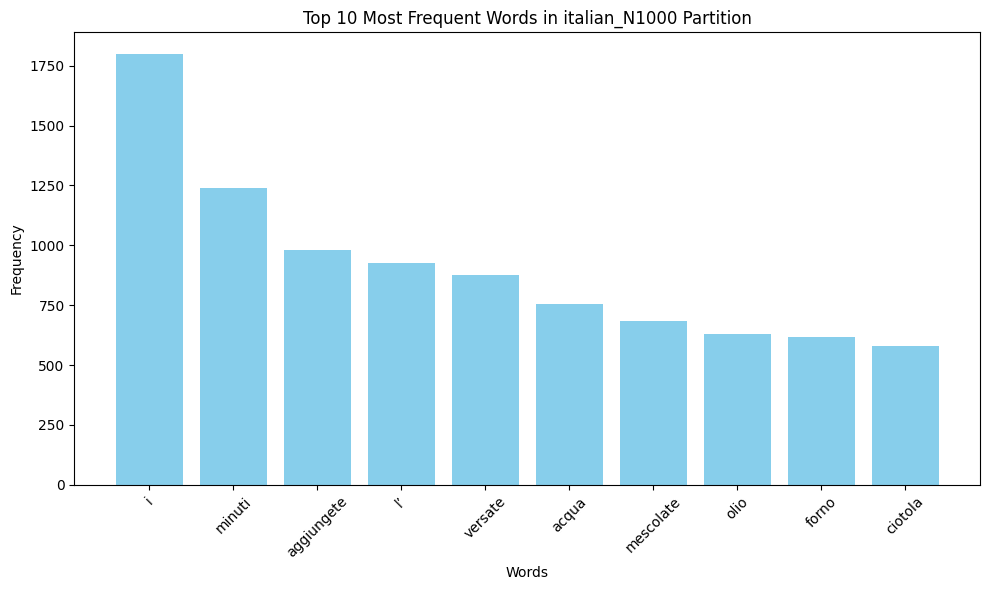

In [10]:
def frequency_distribution(dataset):
    '''
    Computes the frequency distribution of tokenized steps in the dataset.
    The function takes a dataset as input and returns the frequency distribution.
    '''
    token_counter = Counter()
    for el in dataset:
        for step in el["tokenized_steps"]:
            token_counter.update(step)
    return token_counter


def plot_most_common(counter: Counter, x: int = 10, title: str = "Most Common Tokens"):
    """
    Plots the top `x` most common elements in a Counter object.
    
    Parameters:
        counter (Counter): A collections.Counter object with frequencies.
        x (int): Number of most common elements to display.
        title (str): Title of the plot.
    """
    most_common = counter.most_common(x)
    tokens = [item[0] for item in most_common]
    counts = [item[1] for item in most_common]
    
    plt.figure(figsize=(10, 6))
    plt.bar(tokens, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


for name, partition in dataset.items():
    freq_dist = frequency_distribution(partition)
    print(f"Top 10 Most Frequent Words in {name} partition: {freq_dist.most_common(10)}")
    print(f"Number of words in {name} partition: {len(freq_dist)}")
    plot_most_common(freq_dist, x=10, title=f"Top 10 Most Frequent Words in {name} Partition")